Prepared by:
     NAME:LALIT KUMAR CHOUDHARY ,
     ROLL NO.:22103029 ,
     M. TECH. (HYDRAULICS AND WATER RESOURCES ENGINEERING)
         



**NEURAL STYLE TRANSFER**

In [15]:
#Importing necessary dependencies
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display

In [16]:
#Preprocessing of the Images
def load_img(path_to_img):
    max_dim = 256
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [20]:
# #Load the content image and Style image by providing the path

content_image = load_img('/content/crane.png')          #CONTENT IMAGE
style_image = load_img('/content/abstract-art-6994326_960_720.png') #STYLE IMAGE

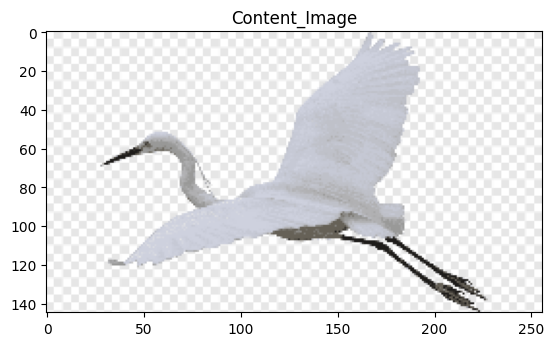

In [36]:
# Function to display an image
def imshow(image, title):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)
imshow(content_image,"Content_Image")


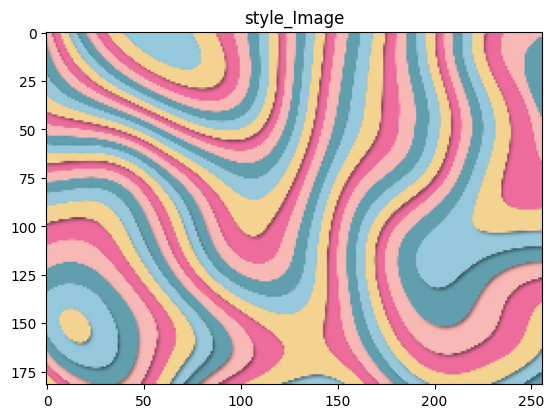

In [37]:
imshow(style_image,"Style_Image")

In [23]:
# Loaded a VGG19 model pre-trained on ImageNet data for features of the corresponding style and content images

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')  #Removed the fully connected layers
vgg.trainable = False

# Function to provide the outputs of a particular convolutional layer of VGG19
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [24]:
# Choose intermediate layers from the network to represent the style and content of the image

content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
#The above layers were chosen based out of Neural transfer Algorithm proposed by **Gatys et. al.** in 2015.**

# Create the model
style_extractor = vgg_layers(style_layers)   # FEATURE REPRESENTATIONS FOR ABOVE LAYERS
content_extractor = vgg_layers(content_layers)

In [26]:
#Class definition to execute different functionalities

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [self.gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

    def gram_matrix(self, input_tensor):
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
        return result/(num_locations)

#Object definition of the above class
extractor = StyleContentModel(style_layers, content_layers)

In [42]:
# Define weights for style and content loss as prposed by Gaty's et al. as
#Total loss=style_weight*style loss+content_weight*content_loss

style_weight=0.01
content_weight=100000

In [43]:
# Run gradient descent
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
image = tf.Variable(content_image)

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [44]:
# Perform optimization
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    style_loss *= style_weight / len(style_layers)
    content_loss *= content_weight / len(content_layers)
    loss = style_loss + content_loss
    print(loss)
    return loss


def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))



None

Train step: 1000
Total time: 54.3


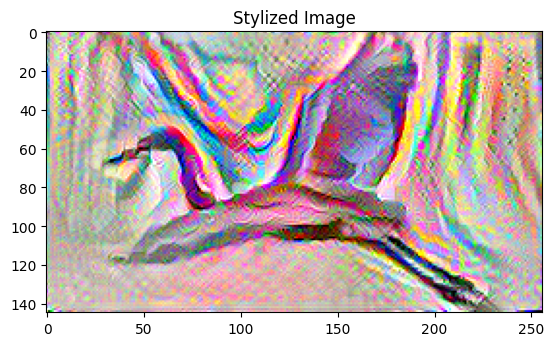

In [45]:
# Update the image with style
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(imshow(image.read_value(),title=None))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# Display the stylized image
imshow(image, 'Stylized Image')

In [83]:
#Converting Tensors into Numpy arrays
c1=tf.squeeze(content_image).numpy()
s1=tf.squeeze(style_image).numpy()
im1=image.numpy()

<Figure size 13500x4500 with 0 Axes>

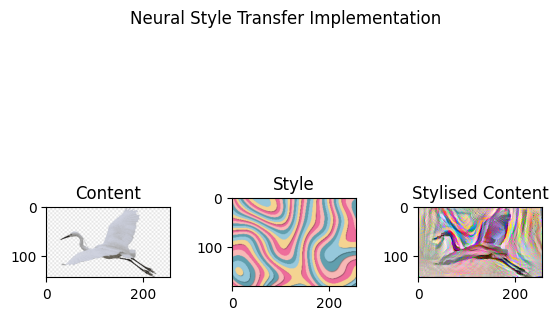

In [104]:
#Plotting operations
plt.figure(figsize=(30,10),dpi=450)
fig,ax=plt.subplots(1,3)
fig.suptitle('Neural Style Transfer Implementation')
ax[0].imshow(c1)
ax[0].set_title("Content")
ax[1].imshow(s1)
ax[1].set_title("Style")
ax[2].imshow(im1)
ax[2].set_title("Stylised Content")
plt.subplots_adjust(wspace=0.5)
plt.show();